# Lab 11: Market Prediction — Exploratory Analysis

<figure>
<a
href="https://colab.research.google.com/github/quinfer/fin510-colab-notebooks/blob/main/labs/lab11_prediction.ipynb"><img
src="https://colab.research.google.com/assets/colab-badge.svg" /></a>
<figcaption>Open in Colab</figcaption>
</figure>

## Objective

This lab develops understanding of market prediction principles through
**exploratory exercises**. You’ll investigate walk-forward validation,
regularization, evaluation metrics, and overfitting—without producing
submission-ready outputs.

**Important**: This is not a template for Coursework 2 Option B. The
scaffold notebook (`labs/coursework2_scaffold.ipynb`) provides that.
This lab teaches you **how to think** about prediction so you can
interpret scaffold outputs intelligently and write critical analysis.

**Time estimate**: 60-90 minutes

## Learning Goals

By the end of this lab, you should be able to:

-   Explain why walk-forward validation prevents look-ahead bias
-   Demonstrate how look-ahead bias inflates performance
-   Compare OLS vs ridge when predictors correlate
-   Interpret R² OOS and directional accuracy
-   Identify overfitting through in-sample vs out-of-sample gaps
-   Ask critical questions about prediction model results

## Setup

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import r2_score
import warnings
warnings.filterwarnings('ignore')

# Display settings
pd.set_option('display.float_format', '{:.4f}'.format)
np.random.seed(42)  # Reproducibility

print("✓ Libraries loaded successfully")

✓ Libraries loaded successfully

## Part 1: Understanding Walk-Forward Validation

### Exercise 1.1: Simulating Walk-Forward Process

Let’s create a simple dataset and manually implement walk-forward
validation to see how it works step-by-step.

In [2]:
# Generate simulated monthly data
n_months = 240  # 20 years
dates = pd.date_range('2004-01-01', periods=n_months, freq='MS')

# Simulate market returns and two factor predictors
np.random.seed(42)
market = np.random.normal(0.008, 0.04, n_months)
factor1 = np.random.normal(0.006, 0.03, n_months)
factor2 = np.random.normal(0.004, 0.035, n_months)

# Create DataFrame
data = pd.DataFrame({
    'date': dates,
    'market': market,
    'factor1': factor1,
    'factor2': factor2
})

# Create target: next month's market return
data['market_next'] = data['market'].shift(-1)

# Remove last row (no future target)
data = data[:-1].copy()

print(f"Data shape: {data.shape}")
print(f"Date range: {data['date'].min()} to {data['date'].max()}")
print("\nFirst few rows:")
data.head()

Data shape: (239, 5)
Date range: 2004-01-01 00:00:00 to 2023-11-01 00:00:00

First few rows:

**Discussion questions:**

1.  What is the “target” variable we’re trying to predict?
2.  Why do we shift market returns by -1 to create the target?
3.  What would happen if we forgot to remove the last row?

### Exercise 1.2: Manual Walk-Forward Implementation

Now implement walk-forward validation manually for first few iterations
to see the process.

In [3]:
# Settings
train_window = 120  # 10 years training
test_start = 120   # Start forecasting at month 120

# Storage for results
predictions = []
actuals = []
train_periods = []

# Walk-forward loop (first 5 iterations for demonstration)
for t in range(test_start, test_start + 5):
    # Training data: rolling window
    train_start = t - train_window
    train_end = t
    
    X_train = data.iloc[train_start:train_end][['factor1', 'factor2']].values
    y_train = data.iloc[train_start:train_end]['market_next'].values
    
    # Test data: next month only
    X_test = data.iloc[t:t+1][['factor1', 'factor2']].values
    y_test = data.iloc[t]['market_next']
    
    # Train model
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # Forecast
    y_pred = model.predict(X_test)[0]
    
    # Store results
    predictions.append(y_pred)
    actuals.append(y_test)
    train_periods.append(f"{data.iloc[train_start]['date'].year}-{data.iloc[train_end-1]['date'].year}")
    
    print(f"\nForecast {t-train_window+1}:")
    print(f"  Training period: {train_periods[-1]}")
    print(f"  Forecast date: {data.iloc[t]['date']}")
    print(f"  Predicted: {y_pred*100:.2f}%")
    print(f"  Actual: {y_test*100:.2f}%")
    print(f"  Error: {(y_pred - y_test)*100:.2f}%")


Forecast 1:
  Training period: 2004-2013
  Forecast date: 2014-01-01 00:00:00
  Predicted: 0.55%
  Actual: -2.84%
  Error: 3.39%

Forecast 2:
  Training period: 2004-2014
  Forecast date: 2014-02-01 00:00:00
  Predicted: 1.50%
  Actual: 6.41%
  Error: -4.91%

Forecast 3:
  Training period: 2004-2014
  Forecast date: 2014-03-01 00:00:00
  Predicted: 0.11%
  Actual: -4.81%
  Error: 4.92%

Forecast 4:
  Training period: 2004-2014
  Forecast date: 2014-04-01 00:00:00
  Predicted: 0.24%
  Actual: 3.15%
  Error: -2.91%

Forecast 5:
  Training period: 2004-2014
  Forecast date: 2014-05-01 00:00:00
  Predicted: 0.72%
  Actual: 9.56%
  Error: -8.84%

**Discussion questions:**

1.  How does the training window change as we move forward in time?
2.  At each forecast date, has the model “seen” the target value during
    training?
3.  Why do we retrain the model at each step rather than training once?
4.  What prevents look-ahead bias in this process?

## Part 2: Demonstrating Look-Ahead Bias

### Exercise 2.1: Comparing Honest vs Biased Testing

Let’s explicitly compare walk-forward validation (honest) vs training on
full sample (look-ahead bias).

In [4]:
def walk_forward_prediction(data, train_window=120):
    """
    Honest walk-forward prediction.
    """
    predictions = []
    actuals = []
    dates = []
    
    for t in range(train_window, len(data)):
        # Training: only past data
        train_start = t - train_window
        X_train = data.iloc[train_start:t][['factor1', 'factor2']].values
        y_train = data.iloc[train_start:t]['market_next'].values
        
        # Test: current observation
        X_test = data.iloc[t:t+1][['factor1', 'factor2']].values
        y_test = data.iloc[t]['market_next']
        
        # Train and predict
        model = LinearRegression()
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)[0]
        
        predictions.append(y_pred)
        actuals.append(y_test)
        dates.append(data.iloc[t]['date'])
    
    return np.array(predictions), np.array(actuals), dates

def biased_prediction(data, train_window=120):
    """
    Biased approach: train on full sample, then "predict" test period.
    This introduces look-ahead bias.
    """
    # Train on ENTIRE dataset (including test period - THIS IS WRONG)
    X_all = data[['factor1', 'factor2']].values
    y_all = data['market_next'].values
    
    model = LinearRegression()
    model.fit(X_all, y_all)
    
    # "Predict" test period (but model already saw this data during training)
    predictions = []
    actuals = []
    dates = []
    
    for t in range(train_window, len(data)):
        X_test = data.iloc[t:t+1][['factor1', 'factor2']].values
        y_test = data.iloc[t]['market_next']
        
        y_pred = model.predict(X_test)[0]
        
        predictions.append(y_pred)
        actuals.append(y_test)
        dates.append(data.iloc[t]['date'])
    
    return np.array(predictions), np.array(actuals), dates

# Run both approaches
pred_honest, actual_honest, dates_honest = walk_forward_prediction(data)
pred_biased, actual_biased, dates_biased = biased_prediction(data)

# Calculate R² for both
def calc_r2_oos(y_true, y_pred):
    """Calculate out-of-sample R²."""
    ss_res = ((y_true - y_pred) ** 2).sum()
    ss_tot = ((y_true - y_true.mean()) ** 2).sum()
    return 1 - (ss_res / ss_tot)

r2_honest = calc_r2_oos(actual_honest, pred_honest)
r2_biased = calc_r2_oos(actual_biased, pred_biased)

print("=== Comparison: Honest vs Biased Testing ===\n")
print(f"Walk-Forward (Honest):  R² OOS = {r2_honest*100:.2f}%")
print(f"Full-Sample (Biased):   R² OOS = {r2_biased*100:.2f}%")
print(f"\nDifference: {(r2_biased - r2_honest)*100:.2f} percentage points")
if abs(r2_honest) > 1e-4:
    print(f"Inflation factor: {r2_biased/r2_honest:.2f}x")
else:
    print("Inflation factor: not well-defined because honest R² is ~0")

=== Comparison: Honest vs Biased Testing ===

Walk-Forward (Honest):  R² OOS = -3.19%
Full-Sample (Biased):   R² OOS = -1.02%

Difference: 2.17 percentage points
Inflation factor: 0.32x

**Discussion questions:**

1.  Which approach has higher R² OOS? Why?
2.  Is the “R² OOS” from biased approach truly out-of-sample?
3.  How much does look-ahead bias inflate performance in this example?
4.  If you deployed the biased model in real-world, would it achieve the
    high R²?
5.  Why is this bias subtle and easy to introduce accidentally?

### Exercise 2.2: Visualising the Difference

Let’s visualize prediction accuracy over time for both approaches.

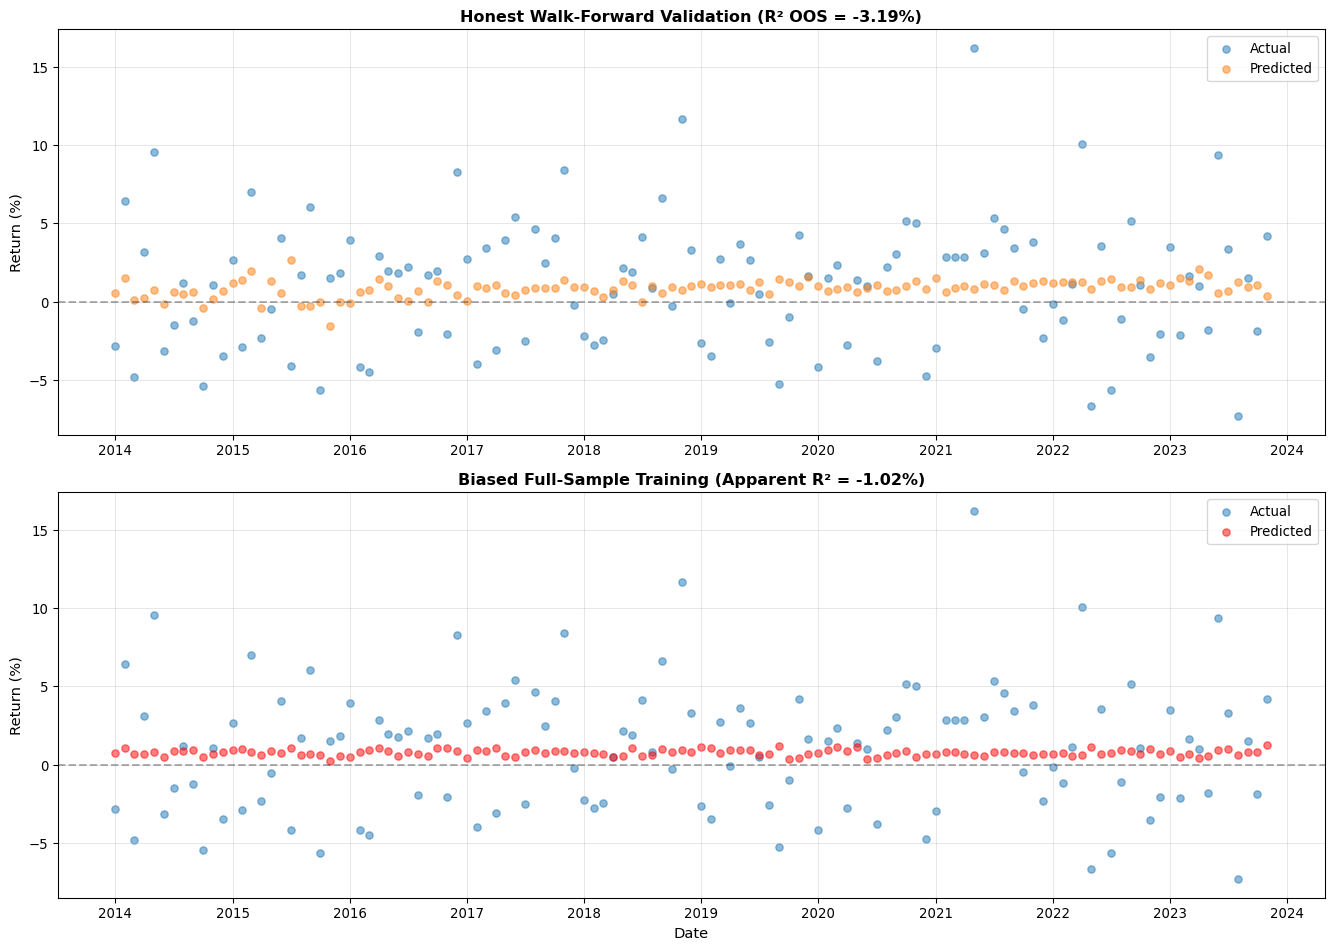


📊 Observation:
   Biased approach shows tighter clustering (predictions closer to actuals)
   This is artificial—model 'saw' the future during training
   Honest approach shows more scatter (realistic forecasting difficulty)

In [5]:
# Plot predictions vs actuals for both methods
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Honest walk-forward
ax1.scatter(dates_honest, actual_honest * 100, alpha=0.5, label='Actual', s=30)
ax1.scatter(dates_honest, pred_honest * 100, alpha=0.5, label='Predicted', s=30)
ax1.set_ylabel('Return (%)', fontsize=11)
ax1.set_title(f'Honest Walk-Forward Validation (R² OOS = {r2_honest*100:.2f}%)', 
              fontsize=12, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.3)

# Biased full-sample
ax2.scatter(dates_biased, actual_biased * 100, alpha=0.5, label='Actual', s=30)
ax2.scatter(dates_biased, pred_biased * 100, alpha=0.5, label='Predicted', s=30, color='red')
ax2.set_xlabel('Date', fontsize=11)
ax2.set_ylabel('Return (%)', fontsize=11)
ax2.set_title(f'Biased Full-Sample Training (Apparent R² = {r2_biased*100:.2f}%)', 
              fontsize=12, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(alpha=0.3)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n📊 Observation:")
print("   Biased approach shows tighter clustering (predictions closer to actuals)")
print("   This is artificial—model 'saw' the future during training")
print("   Honest approach shows more scatter (realistic forecasting difficulty)")

**Discussion questions:**

1.  Visually, which approach shows predictions closer to actuals?
2.  Does tighter clustering mean better true forecasting ability?
3.  In real deployment, which performance would you actually achieve?

**Key insight**: Look-ahead bias makes predictions look artificially
good. Only walk-forward validation reveals true forecasting ability.

## Part 3: OLS vs Ridge Regression

### Exercise 3.1: Creating Multicollinearity

Let’s create correlated predictors to see when ridge outperforms OLS.

In [6]:
# Generate highly correlated factors
n = 240
factor_a = np.random.normal(0, 0.03, n)
factor_b = 0.7 * factor_a + 0.3 * np.random.normal(0, 0.03, n)  # Correlation ~0.7
factor_c = 0.5 * factor_a + 0.5 * np.random.normal(0, 0.03, n)  # Correlation ~0.5

# Target: weak linear relationship with factors (realistic signal strength)
market_ret = (0.02 * factor_a + 0.01 * factor_b + 0.015 * factor_c + 
              np.random.normal(0.008, 0.04, n))

# Create DataFrame
data_multi = pd.DataFrame({
    'market_next': market_ret,
    'factor_a': factor_a,
    'factor_b': factor_b,
    'factor_c': factor_c
})

# Check correlations
print("=== Predictor Correlations ===\n")
print(data_multi[['factor_a', 'factor_b', 'factor_c']].corr().round(3))

=== Predictor Correlations ===

          factor_a  factor_b  factor_c
factor_a    1.0000    0.9110    0.6520
factor_b    0.9110    1.0000    0.5580
factor_c    0.6520    0.5580    1.0000

**Discussion questions:**

1.  What are the correlations between predictors?
2.  Why would high correlation create problems for OLS?
3.  In factor prediction, do you expect factors to be correlated or
    independent?

### Exercise 3.2: Comparing OLS vs Ridge with Walk-Forward

Now test both models using walk-forward validation.

In [7]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score

def walk_forward_compare_models(data, train_window=120):
    """
    Compare OLS vs Ridge using walk-forward validation.
    """
    pred_ols = []
    pred_ridge = []
    actuals = []
    
    for t in range(train_window, len(data)):
        # Training data
        train_start = t - train_window
        X_train = data.iloc[train_start:t][['factor_a', 'factor_b', 'factor_c']].values
        y_train = data.iloc[train_start:t]['market_next'].values
        
        # Test data
        X_test = data.iloc[t:t+1][['factor_a', 'factor_b', 'factor_c']].values
        y_test = data.iloc[t]['market_next']
        
        # OLS
        model_ols = LinearRegression()
        model_ols.fit(X_train, y_train)
        pred_ols.append(model_ols.predict(X_test)[0])
        
        # Ridge (lambda=1.0)
        model_ridge = Ridge(alpha=1.0)
        model_ridge.fit(X_train, y_train)
        pred_ridge.append(model_ridge.predict(X_test)[0])
        
        actuals.append(y_test)
    
    return np.array(pred_ols), np.array(pred_ridge), np.array(actuals)

# Run comparison
pred_ols, pred_ridge, actuals = walk_forward_compare_models(data_multi)

# Calculate R² OOS for both
r2_ols = calc_r2_oos(actuals, pred_ols)
r2_ridge = calc_r2_oos(actuals, pred_ridge)

# Calculate directional accuracy
def directional_accuracy(y_true, y_pred):
    """Calculate fraction of correct sign predictions."""
    return (np.sign(y_true) == np.sign(y_pred)).mean() * 100

dir_acc_ols = directional_accuracy(actuals, pred_ols)
dir_acc_ridge = directional_accuracy(actuals, pred_ridge)

print("=== OLS vs Ridge Comparison (Walk-Forward) ===\n")
print(f"OLS:")
print(f"  R² OOS: {r2_ols*100:.2f}%")
print(f"  Directional Accuracy: {dir_acc_ols:.2f}%")
print(f"\nRidge (λ=1.0):")
print(f"  R² OOS: {r2_ridge*100:.2f}%")
print(f"  Directional Accuracy: {dir_acc_ridge:.2f}%")
print(f"\nDifference:")
print(f"  R² improvement: {(r2_ridge - r2_ols)*100:.2f} pp")
print(f"  Direction improvement: {dir_acc_ridge - dir_acc_ols:.2f} pp")

=== OLS vs Ridge Comparison (Walk-Forward) ===

OLS:
  R² OOS: -6.46%
  Directional Accuracy: 54.17%

Ridge (λ=1.0):
  R² OOS: -2.73%
  Directional Accuracy: 57.50%

Difference:
  R² improvement: 3.73 pp
  Direction improvement: 3.33 pp

**Discussion questions:**

1.  Which model performs better: OLS or ridge?
2.  Is the improvement large or modest?
3.  Why might ridge help when predictors are correlated?
4.  What is the tradeoff ridge makes (hint: bias vs variance)?
5.  If predictors were uncorrelated, would ridge still help?

### Exercise 3.3: Effect of Regularization Strength

Let’s see how different λ values affect performance.

=== Ridge Performance Across λ Values ===

   lambda  R2_OOS
0  0.0100 -4.6940
1  0.1000 -3.2940
2  0.5000 -2.7830
3  1.0000 -2.7310
4  5.0000 -2.7170
5 10.0000 -2.7180

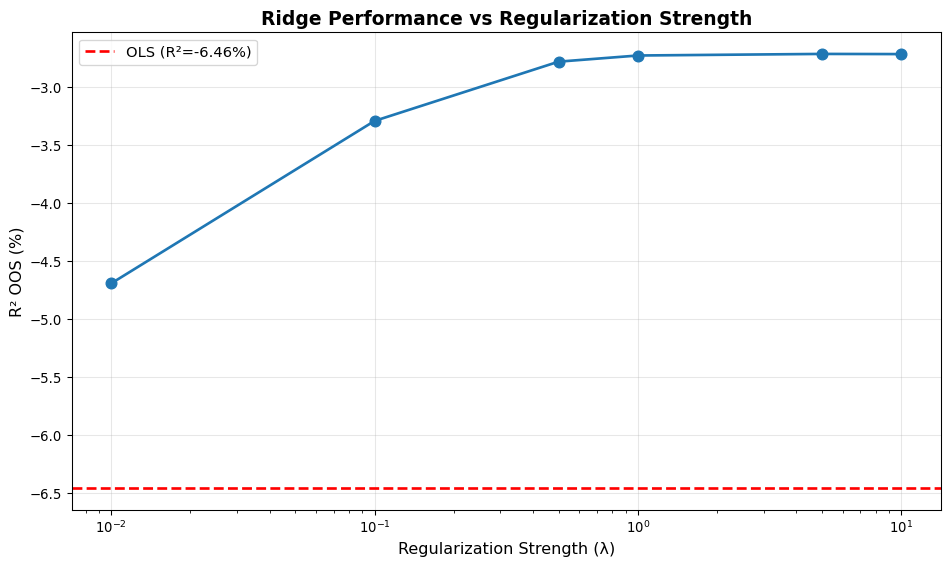

In [8]:
# This cell assumes you have already run the OLS vs Ridge comparison above
# (defines 'actuals' and 'calc_r2_oos').

# Test multiple lambda values
lambdas = [0.01, 0.1, 0.5, 1.0, 5.0, 10.0]
results = []

for lam in lambdas:
    pred_ridge_temp = []
    
    for t in range(120, len(data_multi)):
        train_start = t - 120
        X_train = data_multi.iloc[train_start:t][['factor_a', 'factor_b', 'factor_c']].values
        y_train = data_multi.iloc[train_start:t]['market_next'].values
        X_test = data_multi.iloc[t:t+1][['factor_a', 'factor_b', 'factor_c']].values
        
        model = Ridge(alpha=lam)
        model.fit(X_train, y_train)
        pred_ridge_temp.append(model.predict(X_test)[0])
    
    r2 = calc_r2_oos(actuals, np.array(pred_ridge_temp))
    results.append({'lambda': lam, 'R2_OOS': r2 * 100})

results_df = pd.DataFrame(results)

print("=== Ridge Performance Across λ Values ===\n")
print(results_df.round(3))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(results_df['lambda'], results_df['R2_OOS'], marker='o', linewidth=2, markersize=8)
plt.axhline(y=r2_ols*100, color='red', linestyle='--', linewidth=2, label=f'OLS (R²={r2_ols*100:.2f}%)')
plt.xscale('log')
plt.xlabel('Regularization Strength (λ)', fontsize=12)
plt.ylabel('R² OOS (%)', fontsize=12)
plt.title('Ridge Performance vs Regularization Strength', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Discussion questions:**

1.  What happens to R² OOS as λ increases?
2.  Is there an optimal λ? How would you find it?
3.  What happens with λ→0 (approaches OLS)?
4.  What happens with λ→∞ (extreme shrinkage)?
5.  How would you choose optimal λ for Coursework 2?

**Key insight**: Ridge provides stability when predictors correlate, but
improvement is typically modest (1-2pp). Don’t expect ridge to double
your R² OOS.

## Part 4: Evaluation Metrics Deep Dive

### Exercise 4.1: Understanding R² OOS Components

Let’s decompose what R² OOS actually measures.

In [9]:
# This cell assumes you have already run the OLS vs Ridge section above
# (defines 'actuals' and 'pred_ridge').

# Using ridge predictions from earlier
mean_pred = np.full_like(actuals, actuals.mean())  # Naive benchmark

# Calculate errors
error_model = actuals - pred_ridge
error_benchmark = actuals - mean_pred

# Sum of squared errors
sse_model = (error_model ** 2).sum()
sse_benchmark = (error_benchmark ** 2).sum()

# R² OOS
r2_manual = 1 - (sse_model / sse_benchmark)

print("=== R² OOS Decomposition ===\n")
print(f"Actual return statistics:")
print(f"  Mean: {actuals.mean()*100:.2f}% monthly")
print(f"  Std Dev: {actuals.std()*100:.2f}%")
print(f"\nPrediction errors:")
print(f"  Model SSE: {sse_model:.6f}")
print(f"  Benchmark (mean) SSE: {sse_benchmark:.6f}")
print(f"\nR² OOS calculation:")
print(f"  R² OOS = 1 - (Model SSE / Benchmark SSE)")
print(f"  R² OOS = 1 - ({sse_model:.6f} / {sse_benchmark:.6f})")
print(f"  R² OOS = {r2_manual*100:.2f}%")
print(f"\nInterpretation:")
print(f"  Model reduces prediction error by {r2_manual*100:.1f}% vs naive mean")

=== R² OOS Decomposition ===

Actual return statistics:
  Mean: 1.03% monthly
  Std Dev: 4.10%

Prediction errors:
  Model SSE: 0.207134
  Benchmark (mean) SSE: 0.201629

R² OOS calculation:
  R² OOS = 1 - (Model SSE / Benchmark SSE)
  R² OOS = 1 - (0.207134 / 0.201629)
  R² OOS = -2.73%

Interpretation:
  Model reduces prediction error by -2.7% vs naive mean

**Discussion questions:**

1.  What is the “benchmark” we’re comparing against?
2.  If model SSE \> benchmark SSE, what is R² OOS?
3.  Why is historical mean a reasonable benchmark?
4.  Can R² OOS be negative? What does that mean?
5.  Given monthly return volatility ~4% and mean ~0.8%, what’s the
    maximum possible R²?

### Exercise 4.2: Directional Accuracy Analysis

Let’s examine directional accuracy in detail.

In [10]:
# Calculate detailed directional statistics
signs_actual = np.sign(actuals)
signs_pred = np.sign(pred_ridge)

correct = (signs_actual == signs_pred)
n_correct = correct.sum()
n_total = len(actuals)

# Breakdown by actual sign
positive_months = (actuals > 0)
negative_months = (actuals < 0)

acc_positive = correct[positive_months].mean() * 100
acc_negative = correct[negative_months].mean() * 100

print("=== Directional Accuracy Analysis ===\n")
print(f"Overall directional accuracy: {dir_acc_ridge:.1f}%")
print(f"  Correct predictions: {n_correct} / {n_total}")
print(f"  Benchmark (random): 50.0%")
print(f"\nBreakdown:")
print(f"  Positive months: {positive_months.sum()} occurrences")
print(f"    Accuracy when predicting positive: {acc_positive:.1f}%")
print(f"  Negative months: {negative_months.sum()} occurrences")
print(f"    Accuracy when predicting negative: {acc_negative:.1f}%")

# Statistical significance (binomial test approximation - requires scipy)
from scipy.stats import binom
p_value = 1 - binom.cdf(n_correct - 1, n_total, 0.5)

print(f"\nStatistical test:")
print(f"  Null hypothesis: Directional accuracy = 50% (random guessing)")
print(f"  p-value: {p_value:.4f}")
if p_value < 0.05:
    print(f"  ✓ Reject null: Accuracy significantly > 50% (p < 0.05)")
else:
    print(f"  ✗ Cannot reject null: Accuracy not significantly different from 50%")

=== Directional Accuracy Analysis ===

Overall directional accuracy: 57.5%
  Correct predictions: 69 / 120
  Benchmark (random): 50.0%

Breakdown:
  Positive months: 69 occurrences
    Accuracy when predicting positive: 100.0%
  Negative months: 51 occurrences
    Accuracy when predicting negative: 0.0%

Statistical test:
  Null hypothesis: Directional accuracy = 50% (random guessing)
  p-value: 0.0602
  ✗ Cannot reject null: Accuracy not significantly different from 50%

**Discussion questions:**

1.  Is directional accuracy significantly better than 50%?
2.  Does model predict positive months better than negative months (or
    vice versa)?
3.  If directional accuracy is 54%, is that economically meaningful?
4.  How many correct predictions would you need to be significant at 5%
    level?
5.  Which matters more for market timing: R² OOS or directional
    accuracy?

## Part 5: Detecting Overfitting

### Exercise 5.1: In-Sample vs Out-of-Sample Comparison

Let’s explicitly demonstrate overfitting by comparing in-sample and
out-of-sample performance.

=== In-Sample vs Out-of-Sample Performance ===

OLS:
  In-sample R²: 1.26%
  Out-of-sample R²: -6.46%
  Gap (overfitting): 7.72 pp

Ridge (λ=1.0):
  In-sample R²: 0.16%
  Out-of-sample R²: -2.73%
  Gap (overfitting): 2.89 pp

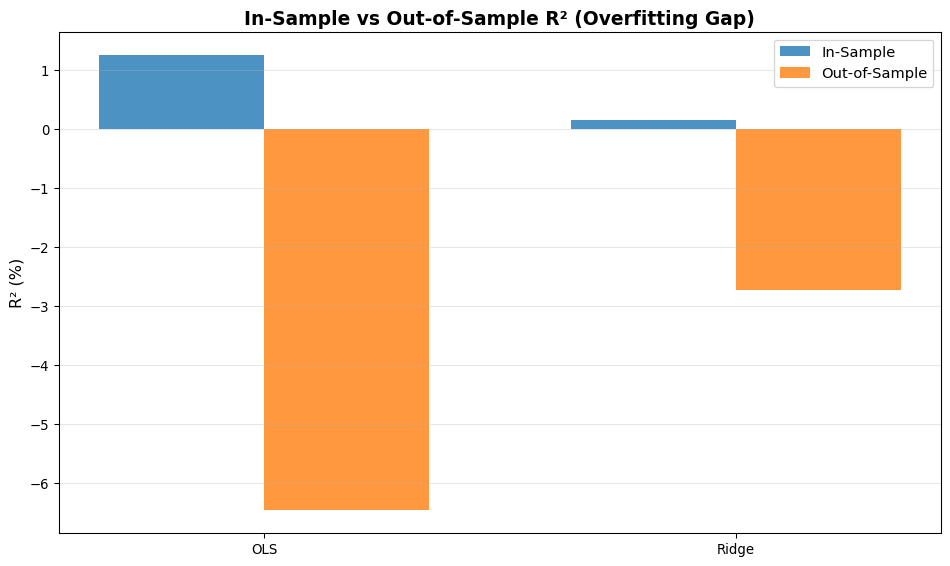

In [11]:
# Using correlated factor data from earlier
train_size = 120
X_train = data_multi.iloc[:train_size][['factor_a', 'factor_b', 'factor_c']].values
y_train = data_multi.iloc[:train_size]['market_next'].values

# Fit models
model_ols = LinearRegression()
model_ols.fit(X_train, y_train)

model_ridge = Ridge(alpha=1.0)
model_ridge.fit(X_train, y_train)

# In-sample predictions (training data)
pred_train_ols = model_ols.predict(X_train)
pred_train_ridge = model_ridge.predict(X_train)

# Out-of-sample predictions (walk-forward on test data)
pred_ols_oos, pred_ridge_oos, actuals_oos = walk_forward_compare_models(data_multi, train_window=120)

# Calculate R² for both
r2_train_ols = r2_score(y_train, pred_train_ols)
r2_train_ridge = r2_score(y_train, pred_train_ridge)
r2_test_ols = calc_r2_oos(actuals_oos, pred_ols_oos)
r2_test_ridge = calc_r2_oos(actuals_oos, pred_ridge_oos)

print("=== In-Sample vs Out-of-Sample Performance ===\n")
print("OLS:")
print(f"  In-sample R²: {r2_train_ols*100:.2f}%")
print(f"  Out-of-sample R²: {r2_test_ols*100:.2f}%")
print(f"  Gap (overfitting): {(r2_train_ols - r2_test_ols)*100:.2f} pp")
print(f"\nRidge (λ=1.0):")
print(f"  In-sample R²: {r2_train_ridge*100:.2f}%")
print(f"  Out-of-sample R²: {r2_test_ridge*100:.2f}%")
print(f"  Gap (overfitting): {(r2_train_ridge - r2_test_ridge)*100:.2f} pp")

# Visualize
fig, ax = plt.subplots(figsize=(10, 6))
models = ['OLS', 'Ridge']
in_sample = [r2_train_ols*100, r2_train_ridge*100]
out_sample = [r2_test_ols*100, r2_test_ridge*100]

x = np.arange(len(models))
width = 0.35

ax.bar(x - width/2, in_sample, width, label='In-Sample', alpha=0.8)
ax.bar(x + width/2, out_sample, width, label='Out-of-Sample', alpha=0.8)

ax.set_ylabel('R² (%)', fontsize=12)
ax.set_title('In-Sample vs Out-of-Sample R² (Overfitting Gap)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

**Discussion questions:**

1.  Which model has a larger overfitting gap: OLS or ridge?
2.  Why does ridge have a smaller gap?
3.  If in-sample R² = 15% but OOS R² = 2%, what does that suggest?
4.  Is some overfitting gap inevitable?
5.  What size gap would make you worried about overfitting?

### Exercise 5.2: Overfitting with Too Many Predictors

Let’s demonstrate what happens when we add too many predictors relative
to sample size.

In [12]:
# Generate many (mostly irrelevant) predictors
n = 120  # Small sample
n_relevant = 3
n_noise = 15  # Many noise predictors

# True predictors (small effect)
X_relevant = np.random.normal(0, 0.03, (n, n_relevant))
# Noise predictors
X_noise = np.random.normal(0, 0.03, (n, n_noise))

# Combine
X_all = np.hstack([X_relevant, X_noise])

# Target: only depends on first 3 predictors + noise
y = (0.02 * X_relevant[:, 0] + 0.01 * X_relevant[:, 1] + 
     0.015 * X_relevant[:, 2] + np.random.normal(0.008, 0.04, n))

# Split: first 80 for training, rest for testing
train_size = 80
X_train = X_all[:train_size]
y_train = y[:train_size]
X_test = X_all[train_size:]
y_test = y[train_size:]

# Fit OLS
model_overfit = LinearRegression()
model_overfit.fit(X_train, y_train)

# In-sample and out-of-sample R²
r2_in = model_overfit.score(X_train, y_train)
pred_test = model_overfit.predict(X_test)
r2_out = calc_r2_oos(y_test, pred_test)

print("=== Overfitting with Too Many Predictors ===\n")
print(f"Data:")
print(f"  Training observations: {train_size}")
print(f"  Number of predictors: {X_all.shape[1]}")
print(f"  Observations per predictor: {train_size / X_all.shape[1]:.1f}")
print(f"\nPerformance:")
print(f"  In-sample R²: {r2_in*100:.2f}%")
print(f"  Out-of-sample R²: {r2_out*100:.2f}%")
print(f"  Overfitting gap: {(r2_in - r2_out)*100:.2f} pp")
print(f"\n⚠️ Warning: {X_all.shape[1]} predictors with only {train_size} observations")
print(f"   Severe overfitting—model fits training noise, not signal")

=== Overfitting with Too Many Predictors ===

Data:
  Training observations: 80
  Number of predictors: 18
  Observations per predictor: 4.4

Performance:
  In-sample R²: 17.69%
  Out-of-sample R²: -52.14%
  Overfitting gap: 69.83 pp

⚠️ Warning: 18 predictors with only 80 observations
   Severe overfitting—model fits training noise, not signal

**Discussion questions:**

1.  How many observations per predictor do we have?
2.  What happens to in-sample R² with many predictors?
3.  What happens to out-of-sample R² with many predictors?
4.  What’s the overfitting gap?
5.  For monthly data with 120-month training window, how many predictors
    is reasonable?

**Key insight**: With limited data, keep predictors ≤ 10. More
predictors → overfitting, even with regularization.

## Part 6: Connecting to Coursework 2

### What You’ve Learned vs. What You’ll Apply

**Today’s lab explored concepts:**

-   Walk-forward validation prevents look-ahead bias (honest OOS
    testing)
-   Look-ahead bias inflates performance dramatically (10+ pp)
-   Ridge helps when predictors correlate, but improvement is modest
    (1-2pp)
-   R² OOS = 2-3% is meaningful for monthly returns (signal is weak)
-   Directional accuracy \> 55% indicates timing skill
-   Large in-sample vs OOS gap reveals overfitting (\>5pp is concerning)

**For Coursework 2 Option B, you’ll:**

1.  Use scaffold notebook to run walk-forward validation on JKP factor
    data
2.  Interpret R² OOS results using understanding developed today
3.  Compare OLS vs ridge and explain why one performs better
4.  Write critical analysis discussing overfitting, realism of results,
    limitations
5.  Engage with Gu et al. (2020) on prediction literature
6.  Assess whether prediction model would be exploitable after costs

### Critical Analysis Questions to Ask

When interpreting your Coursework 2 Option B results, ask:

**Methodological questions:**

-   Does walk-forward validation prevent look-ahead bias?
-   Is training window size appropriate (10 years = 120 months typical)?
-   Did I optimize any parameters using test data (introduces bias)?

**Performance questions:**

-   Is R² OOS positive? (If no, model failed)
-   Is R² OOS realistic for monthly returns? (2-3% is meaningful, 10%+
    suspicious)
-   How does R² OOS compare to Gu et al. (2020) benchmarks?
-   Is directional accuracy significantly \> 50%?

**Model comparison questions:**

-   Why did ridge beat/lose to OLS? (Multicollinearity? Sample size?)
-   Is improvement economically meaningful or within sampling error?
-   Are coefficients stable across training windows?

**Overfitting questions:**

-   What’s the in-sample vs OOS gap? (\>5pp indicates overfitting)
-   Does R² OOS decline in later test periods? (Suggests initial luck)
-   How many predictors relative to training sample size? (Rule of
    thumb: ≤10)

**Economic questions:**

-   Would strategy be profitable after transaction costs? (~3-4% annual
    drag from monthly rebalancing)
-   What’s the certainty equivalent return gain? (Extension for advanced
    students)
-   Would practitioner implement this model in real portfolio?

**Limitations to acknowledge:**

-   Limited training sample (only 10-15 years)
-   No regime switching (assumes stable relationships)
-   Simplified asset allocation (binary long/short)
-   Transaction cost estimates are rough
-   Model may have overfit despite regularization

### Next Steps

1.  **Read Gu et al. (2020)**: “Empirical Asset Pricing via Machine
    Learning” — Essential benchmark for prediction research
2.  **Run scaffold notebook**: See what actual JKP factor prediction
    outputs look like
3.  **Choose factors wisely**: Use 5-8 factors (not 20) to avoid
    overfitting
4.  **Draft interpretation**: Practice writing critical analysis
    paragraphs
5.  **Office hours**: Ask conceptual questions about interpretation

## Summary

Today’s lab developed principles for market prediction:

-   **Walk-forward validation** is essential—only way to prevent
    look-ahead bias
-   **Look-ahead bias** inflates performance 2-10pp—makes useless models
    look good
-   **Ridge regression** stabilizes predictions when factors correlate,
    but improvement is modest
-   **R² OOS = 2-3%** is meaningful for monthly returns—don’t expect 20%
-   **Directional accuracy \> 55%** indicates timing skill, but must be
    statistically tested
-   **In-sample vs OOS gap** reveals overfitting—gap \>5pp is concerning
-   **Critical interpretation** asks questions, contextualizes results,
    acknowledges limitations

**These principles enable critical analysis**—the 35% component of
Coursework 2 Option B. Scaffold provides outputs; understanding provides
interpretation. Focus your effort on thinking deeply about what results
mean, not on perfecting code.

**Week 10 + Week 11 together**: You now have principles for both
coursework options (replication and prediction). Choose based on
interest—both are equally challenging at the interpretation level. Both
require honest testing, realistic expectations, and critical thinking.